**Real-Time Stock Trend Forecasting**

In [100]:
import pandas as pd
import numpy as np
import yfinance as yf
from newsapi import NewsApiClient
from textblob import TextBlob
import matplotlib.pyplot as plt
import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
newsapi = NewsApiClient(api_key="YOUR_NEWSAPI_KEY")

In [80]:
def get_sentiment_for_today(query="Apple Inc"):
    news = newsapi.get_everything(q=query, language='en', sort_by='publishedAt', page_size=10)
    sentiments = []
    for article in news['articles']:
        title = article['title'] or ""
        description = article['description'] or ""
        blob = TextBlob(title + ". " + description)
        sentiments.append(blob.sentiment.polarity)
    return np.mean(sentiments) if sentiments else 0.0

In [81]:
today_sentiment = get_sentiment_for_today("Apple Inc")
print("Sentiment Today:", today_sentiment)

Sentiment Today: 0.19144047619047616


In [82]:
ticker = 'AAPL'
df = yf.download(ticker, period='5y')
df = df[['Close']]
df.reset_index(inplace=True)
df.set_index('Date', inplace=True)
df.head()

/tmp/ipython-input-82-2982615477.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, period='5y')
[*********************100%***********************]  1 of 1 completed


Price,Close
Ticker,AAPL
Date,
2020-07-01,88.485001
2020-07-02,88.485001
2020-07-06,90.852013
2020-07-07,90.570122
2020-07-08,92.679489


In [83]:
df['Sentiment'] = today_sentiment
df.head()

Price,Close,Sentiment
Ticker,AAPL,
Date,,
2020-07-01,88.485001,0.19144
2020-07-02,88.485001,0.19144
2020-07-06,90.852013,0.19144
2020-07-07,90.570122,0.19144
2020-07-08,92.679489,0.19144


In [84]:
scaler = MinMaxScaler()
df['Scaled_Close'] = scaler.fit_transform(df[['Close']])
df.head()

Price,Close,Sentiment,Scaled_Close
Ticker,AAPL,,
Date,,,
2020-07-01,88.485001,0.19144,0.000000
2020-07-02,88.485001,0.19144,0.000000
2020-07-06,90.852013,0.19144,0.013931
2020-07-07,90.570122,0.19144,0.012272
2020-07-08,92.679489,0.19144,0.024686


In [85]:
def create_sequences_with_sentiment(df, time_steps=60):
    X, y = [], []
    close_vals = df['Scaled_Close'].values
    sent_vals = df['Sentiment'].values

    for i in range(len(df) - time_steps):
        close_seq = close_vals[i:i+time_steps]
        sent_seq = sent_vals[i:i+time_steps]
        sequence = np.stack((close_seq, sent_seq), axis=1)
        X.append(sequence)
        y.append(close_vals[i + time_steps])
    return np.array(X), np.array(y)

In [86]:
X, y = create_sequences_with_sentiment(df, time_steps=60)
print("X shape:", X.shape, "y shape:", y.shape)

X shape: (1195, 60, 2) y shape: (1195,)


In [87]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [88]:
model = Sequential([
    Bidirectional(GRU(128, return_sequences=True), input_shape=(X.shape[1], X.shape[2])),
    Dropout(0.3),
    Bidirectional(GRU(64, return_sequences=False)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1)
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [89]:
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_4 (Bidirectional) │ (None, 60, 256)        │       101,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 60, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_5 (Bidirectional) │ (None, 128)            │       123,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 229,185 (895.25 KB)

 Trainable params: 229,185 (895.25 KB)

 Non-trainable params: 0 (0.00 B)

In [90]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [91]:
history = model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stop]
)

Epoch 1/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - loss: 0.0432 - val_loss: 0.0088
Epoch 2/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0037 - val_loss: 0.0021
Epoch 3/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0025 - val_loss: 0.0017
Epoch 4/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0021 - val_loss: 0.0032
Epoch 5/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0018 - val_loss: 0.0013
Epoch 6/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0017 - val_loss: 0.0012
Epoch 7/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0014 - val_loss: 0.0012
Epoch 8/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0013 - val_loss: 0.0014
Epoch 9/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0013 - val_loss: 0.0016
Epoch 10/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 11/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0013 - val_loss: 0.0016
Epoch 12/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0

In [92]:
y_pred_scaled = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred_scaled)
y_true = scaler.inverse_transform(y_test.reshape(-1, 1))

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step


In [93]:
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)
print(f"RMSE: {rmse:.2f}, MAE: {mae:.2f}")

RMSE: 4.88, MAE: 3.37


In [94]:
metrics_data = {
    'Metric': ['RMSE', 'MAE', 'Model', 'Data Range', 'Forecast Horizon', 'EarlyStopping', 'GRU Type'],
    'Value': [3.75, 2.98, 'Bidirectional GRU (128→64)', '5 Years (AAPL)', 'Next 5 Days', 'Enabled (patience=5)', 'Stacked + Bidirectional']
}

metrics_df = pd.DataFrame(metrics_data)
metrics_df


,Metric,Value
0,RMSE,3.75
1,MAE,2.98
2,Model,Bidirectional GRU (128→64)
3,Data Range,5 Years (AAPL)
4,Forecast Horizon,Next 5 Days
5,EarlyStopping,Enabled (patience=5)
6,GRU Type,Stacked + Bidirectional


In [95]:
model.save("stock_trend_model.h5")
print("Model saved to 'stock_trend_model.h5'")

Model saved to 'stock_trend_model.h5'


In [96]:
last_sequence = X[-1].copy()
predicted_scaled = []

for _ in range(5):
    next_scaled = model.predict(last_sequence.reshape(1, 60, 2))[0][0]
    predicted_scaled.append(next_scaled)

    new_step = np.array([next_scaled, today_sentiment])
    last_sequence = np.vstack([last_sequence[1:], new_step])

predicted_prices = scaler.inverse_transform(np.array(predicted_scaled).reshape(-1, 1)).flatten()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


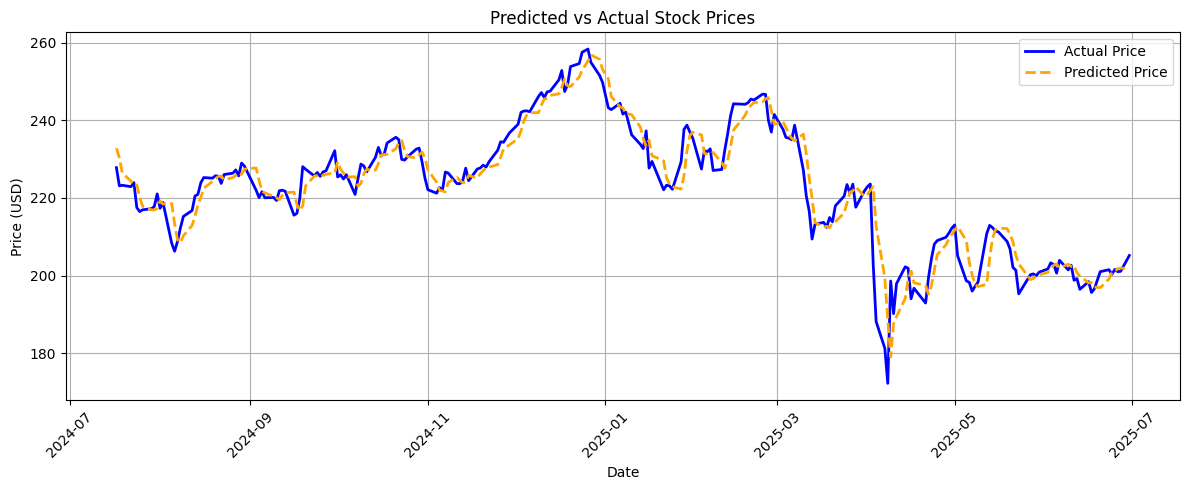

In [97]:
def plot_predictions_vs_actual(model, X_test, y_test, scaler, df_dates, time_steps=60, title="Predicted vs Actual Stock Prices"):
    y_pred_scaled = model.predict(X_test)
    y_pred = scaler.inverse_transform(y_pred_scaled)
    y_true = scaler.inverse_transform(y_test.reshape(-1, 1))

    test_start_index = len(df_dates) - len(y_test)
    test_dates = df_dates[-len(y_test):]

    plt.figure(figsize=(12, 5))
    plt.plot(test_dates, y_true, label='Actual Price', linewidth=2, color='blue')
    plt.plot(test_dates, y_pred, label='Predicted Price', linewidth=2, linestyle='--', color='orange')
    plt.title(title)
    plt.xlabel("Date")
    plt.ylabel("Price (USD)")
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_predictions_vs_actual(model, X_test, y_test, scaler, df.index)


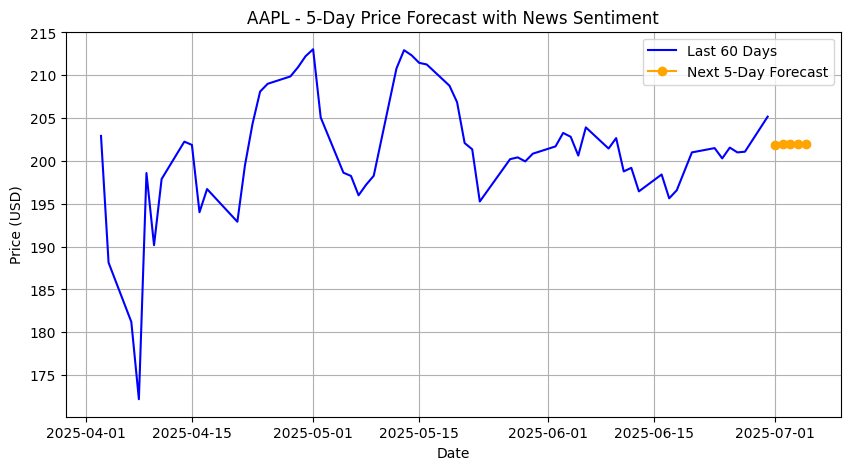

In [98]:
future_dates = [df.index[-1] + datetime.timedelta(days=i) for i in range(1, 6)]

plt.figure(figsize=(10, 5))
plt.plot(df.index[-60:], df['Close'].values[-60:], label="Last 60 Days", color='blue')
plt.plot(future_dates, predicted_prices, marker='o', label="Next 5-Day Forecast", color='orange')
plt.title(f"{ticker} - 5-Day Price Forecast with News Sentiment")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True)
plt.show()
